<a href="https://colab.research.google.com/github/kirubanath/AI-DS_learnings/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Semantic image segmentation is a task in computer vision where the goal is to assign a class label to each pixel in an image. The goal of semantic segmentation is to classify each pixel in an image to its corresponding class. It's different from instance segmentation, where the goal is to detect and segment individual objects within an image.

For example, in an image containing a person, a car, and a building, semantic segmentation would classify each pixel as belonging to one of these classes: person, car, building, background, etc. This task is challenging because it requires the model to not only identify the object in the image but also understand its shape and boundaries.

Semantic image segmentation is a fundamental task in computer vision and is used in a wide range of applications such as object detection, scene understanding, self-driving cars, and medical imaging.

The goal of this assignment is to train a deep learning model to perform semantic image segmentation on the COCO dataset. The COCO dataset consists of 80 object categories and a total of 330,000 images. The task is to predict a class label for every pixel in an image. 

*   Start by downloading the COCO dataset from the official website and split it into train, validation, and test sets. **(2 points)**

*   Preprocess the data by converting the images to grayscale and normalizing the pixel values. **(5 points)**

*   Build a deep learning model using a convolutional neural network (CNN) architecture. You can use a pre-trained model such as ResNet or VGG as a starting point. **(8 points)**


*   Use an encoder-decoder architecture with skip connections to improve the segmentation performance. **(2 points)**

*   Use a combination of different loss functions to optimize the model. **(2 points)**

*   **Bonus** : Use techniques such as data augmentation and transfer learning to improve the performance of the model. **(0 points)**

*   **Bonus** : Use techniques such as non-maximum suppression to post-process the output of the model and improve the final segmentation results. **(0 points)**

*   Evaluate the performance of the model on the validation and test sets using metrics such as Intersection over Union (IoU) and mean pixel accuracy. Plot graphs wherever necessary **(3 points)**


*   Write a report describing the model architecture, training process, evaluation results, and discussion of the results. **(3 points)**



The aim of the assignment is to get you familiarised with CNNs and the practices followd in industry. While SOTA could be the eventual dream, doing so now might come at the expense of exhausting your premium GPU. Also, succesfully attempting the bonus sections will help with a grade boost if you falter in any other sections. The code should have proper headers and comments for all sections with points.

The classes you would have to include for training are : 'person', 'chair', 'car', 'dining table', 'cup', 'bottle', 'bowl', 'handbag', 'truck', 'bench', 'backpack', 'book', 'cell phone', 'sink', 'clock', 'tv', 'potted plant', 'couch', 'dog', 'knife', 'sports ball', 'traffic light', 'cat', 'umbrella', 'bus'

For the output, you could do one of the two methods on 10 random images. This should be done in the report section. The image id should be generated randomly on the length of the test data.

Display the image and provide bounding boxes. The annotations should be all the classes present in the image and the background. Compare against actual annotations and include in report.
The output would have annotations for each pixel. You should display the  image and unique list of annotations. Compare against actual annotations and include in report.

---

##0. Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


import json
import skimage.io as io
from skimage.color import rgb2gray
import random
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

from keras.layers import *
from keras.models import Sequential, Model

import h5py


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d awsaf49/coco-2017-dataset

100% 25.0G/25.0G [02:48<00:00, 140MB/s]
100% 25.0G/25.0G [02:48<00:00, 160MB/s]


In [ ]:
!unzip /content/coco-2017-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: coco2017/val2017/000000000139.jpg  
  inflating: coco2017/val2017/000000000285.jpg  
  inflating: coco2017/val2017/000000000632.jpg  
  inflating: coco2017/val2017/000000000724.jpg  
  inflating: coco2017/val2017/000000000776.jpg  
  inflating: coco2017/val2017/000000000785.jpg  
  inflating: coco2017/val2017/000000000802.jpg  
  inflating: coco2017/val2017/000000000872.jpg  
  inflating: coco2017/val2017/000000000885.jpg  
  inflating: coco2017/val2017/000000001000.jpg  
  inflating: coco2017/val2017/000000001268.jpg  
  inflating: coco2017/val2017/000000001296.jpg  
  inflating: coco2017/val2017/000000001353.jpg  
  inflating: coco2017/val2017/000000001425.jpg  
  inflating: coco2017/val2017/000000001490.jpg  
  inflating: coco2017/val2017/000000001503.jpg  
  inflating: coco2017/val2017/000000001532.jpg  
  inflating: coco2017/val2017/000000001584.jpg  
  inflating: coco2017/val2017/000000001675.jpg  
  inflating: coco2

##1. Downloading and preprocessing the Dataset:

To do this I am making use of the Pycoco library

In [ ]:
from pycocotools.coco import COCO

In [ ]:
#using the dataset present in kaggle
data_dir = '/content/coco2017'

In [ ]:
#defining the classes required:
classes = ['person', 'car', 'bus', 'truck', 'traffic light', 'bench', 'cat', 'dog', 'backpack', 'umbrella', 'handbag', 'sports ball', 'bottle', 'cup', 'knife', 'bowl', 'chair', 'couch', 'potted plant', 'dining table', 'tv', 'cell phone', 'sink', 'book', 'clock']

In [ ]:
#loading the annotations file for both train and validation set:
train_ann = COCO(f'{data_dir}/annotations/instances_train2017.json')
val_ann   = COCO(f'{data_dir}/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=16.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


In [ ]:
#getting the IDs of all classes:
Ids = train_ann.getCatIds()
categories = train_ann.loadCats(Ids)

In [ ]:
categories

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [ ]:
#now getting the ids of our required classes
class_ids = {}
for dic in categories:
  if dic['name'] in classes:
    class_ids[dic['name']] = dic['id']

In [ ]:
class_ids

{'person': 1,
 'car': 3,
 'bus': 6,
 'truck': 8,
 'traffic light': 10,
 'bench': 15,
 'cat': 17,
 'dog': 18,
 'backpack': 27,
 'umbrella': 28,
 'handbag': 31,
 'sports ball': 37,
 'bottle': 44,
 'cup': 47,
 'knife': 49,
 'bowl': 51,
 'chair': 62,
 'couch': 63,
 'potted plant': 64,
 'dining table': 67,
 'tv': 72,
 'cell phone': 77,
 'sink': 81,
 'book': 84,
 'clock': 85}

In [ ]:
#gettingthe reverse dictionary for ease later on:
class_names = {}
for key,val in class_ids.items():
  class_names[val] = key

In [ ]:
#To Extract Image IDs
def create_images_dict(data = 'train'):
    #Loading the Annotation File
    if data == 'train':
        coco = train_ann
    elif data == 'val':
        coco = val_ann
    
    all_images = set()
    for cls, ids in class_ids.items():
        imgids = coco.getImgIds(catIds = [ids])
        all_images = all_images.union(set(imgids))
    
    all_images = list(all_images)
    return coco.loadImgs(all_images)

In [ ]:
IDS = []
for n in classes:
    IDS.append(class_ids[n])
print(IDS)

#the order here is same as the one defined above

[1, 3, 6, 8, 10, 15, 17, 18, 27, 28, 31, 37, 44, 47, 49, 51, 62, 63, 64, 67, 72, 77, 81, 84, 85]


In [ ]:
def read_img(d, data='train'):
    """
    Reads an image and mask from it's dictionary file retrieved via pycoco
    """
    
    #We'll resize every image to 224x224
    image_size = (224,224)
    if data == 'train':
        coco = train_ann
    elif data == 'val':
        coco = val_ann
    
    #Reading the Image and converting them into greyscale
    X = io.imread(data_dir+'/'+data+'2017/'+d['file_name'])
    if len(X.shape) > 2: #Some images are already grayscaled
        X = rgb2gray(X) #Grayscale
    X = cv2.resize(X, image_size)/255 #Normalizing
    
    #Creating label encoded mask - 0 for background, from 1 to 25 for the classes in the order specified above
    mask = np.zeros(image_size)
        
    for idx, c in enumerate(IDS):
        annids = coco.getAnnIds(imgIds=d['id'], catIds=c)
        annotations = coco.loadAnns(annids)
        
        #Merging annotations for a single category
        m = np.zeros(image_size)
        for an in annotations:
            mz = coco.annToMask(an)
            m += cv2.resize(mz, image_size)
        #Some pixels belong to more than one instance - so they'll have a value higher than 1
        m = np.minimum(np.ones(image_size), m)
        
        #Adding it into our mask
        mask += m * (idx+1)
    
    #Inserting new dimension so that it can be fed into the tensorflow model
    X = np.expand_dims(X, 2)
    # mask = np.expand_dims(mask,2)
    

    
    return X, mask
  
  



In [ ]:
def onehot_mask(m):
    if len(m.shape) > 2:
      m = m[:,:,0]
    mask = np.zeros((m.shape[0], m.shape[1], 26)).astype('float')

    for i in range(26):
      x_ind,y_ind = np.where(m==i)
      mask[x_ind,y_ind,i] = 1
    
    return mask

In [ ]:
#creating a function to visualize an image and its mask:
def viz(x,y):
  x = x.reshape(224,224)
  # y = y.reshape(224,224)
  fig,ax = plt.subplots(1,2,figsize = (10,8))

  ax[0].imshow(x,cmap = 'gray')
  ax[1].imshow(y)
  plt.show()

In [ ]:
#creating the train and validation images:
train_img = create_images_dict()
val_img   = create_images_dict(data = 'val')

In [ ]:
len(train_img)

95037

In [ ]:
len(val_img)

4027

In [ ]:
#selecting a random image and vizualizing it:
img, mask = read_img(train_img[10])


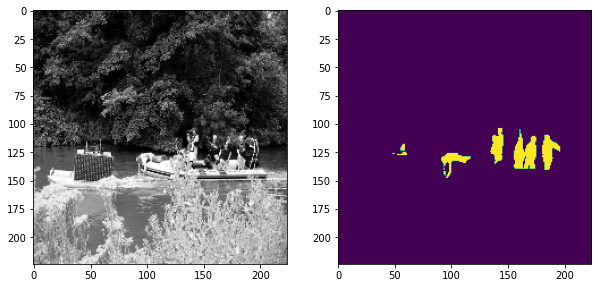

In [ ]:
viz(img,mask)

In [ ]:
test_img = os.listdir('/content/coco2017/test2017')

#function to get the test images to test later on
def read_test(i):
  image_size = (224,224)
  X = io.imread(data_dir+'/test2017/'+test_img[i])
  if len(X.shape) > 2:
    X = rgb2gray(X)
  X = cv2.resize(X,image_size)/255

  X = np.expand_dims(X,2)
  return X

**Now that we have downloaded the dataset and created the required splits, we have to make a generator function that provides the input to our model**

In [ ]:
def train_gen(batch_size):
  k = 0
  while True:
    X = np.zeros((batch_size,224,224,1)).astype('float')
    y = np.zeros((batch_size,224,224,26)).astype('float')

    for i in range(k , k+batch_size):
      img,mask = read_img(train_img[i],data = 'train')

      X[i-k] = img
      y[i-k] = onehot_mask(mask)
    
    k+=batch_size

    if k+batch_size >= 95000:
      k = 0
      random.shuffle(train_img)

    yield X,y 


def val_gen(batch_size):
  k = 0
  while True:
    X = np.zeros((batch_size,224,224,1)).astype('float')
    y = np.zeros((batch_size,224,224,26)).astype('float')

    for i in range(k , k+batch_size):
      img,mask = read_img(val_img[i],data = 'val')

      X[i-k] = img
      y[i-k] = onehot_mask(mask)
    
    k+=batch_size

    if k+batch_size >= 4000:
      k = 0
      random.shuffle(val_img)

    yield X,y 

## Building Models:

### Model1: VGG structure with no skip connections



In [ ]:
model1 = Sequential([
    Input(shape = (224,224,1)),

    #encoder:

    Conv2D(64,(3,3),activation = 'relu',padding = 'same'),
    Conv2D(64,(3,3),activation = 'relu',padding = 'same'),
    MaxPool2D((2,2),strides=(2,2)),

    Conv2D(128,(3,3),activation = 'relu',padding = 'same'),
    Conv2D(128,(3,3),activation = 'relu',padding = 'same'),
    MaxPool2D((2,2),strides=(2,2)),

    Conv2D(256,(3,3),activation = 'relu',padding = 'same'),
    Conv2D(256,(3,3),activation = 'relu',padding = 'same'),
    Conv2D(256,(3,3),activation = 'relu',padding = 'same'),
    MaxPool2D((2,2),strides=(2,2)),

    Conv2D(512,(3,3),activation = 'relu',padding = 'same'),
    Conv2D(512,(3,3),activation = 'relu',padding = 'same'),
    Conv2D(512,(3,3),activation = 'relu',padding = 'same'),
    MaxPool2D((2,2),strides=(2,2)),

    # decoder:
    Conv2DTranspose(512,(3,3),strides = (2,2),activation = 'relu', padding = 'same'),
    Conv2DTranspose(512,(3,3),activation = 'relu', padding = 'same'),
    Conv2DTranspose(512,(3,3),activation = 'relu', padding = 'same'),

    Conv2DTranspose(256,(3,3),strides = (2,2),activation = 'relu', padding = 'same'),
    Conv2DTranspose(256,(3,3),activation = 'relu', padding = 'same'),
    Conv2DTranspose(256,(3,3),activation = 'relu', padding = 'same'),

    Conv2DTranspose(128,(3,3),strides = (2,2),activation = 'relu', padding = 'same'),
    Conv2DTranspose(128,(3,3),activation = 'relu', padding = 'same'),

    Conv2DTranspose(64,(3,3),strides = (2,2),activation = 'relu', padding = 'same'),
    Conv2DTranspose(64,(3,3),activation = 'relu', padding = 'same'),

    #output:
    Conv2D(26,(1,1),activation = 'softmax', padding = 'same')
])

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [ ]:
!pip install segmentation-models --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 7.8 MB/s eta 0:00:00


In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
model1.compile(
    optimizer = 'adam',
    loss      = sm.losses.JaccardLoss(),
    metrics   = [sm.metrics.IOUScore()]
)

In [ ]:
batch_size = 20

history1 = model1.fit(
    train_gen(batch_size),
    validation_data = val_gen(batch_size),
    steps_per_epoch = 95000//batch_size,
    validation_steps = 4000//batch_size,
    epochs = 1,
    verbose = True
)

4750/4750 [==============================] - 3212s 676ms/step - loss: 0.7929 - iou_score: 0.2071 - val_loss: 0.7895 - val_iou_score: 0.2105


As we can see above, the accuracy of the model is very low from the IOU value we got. Let us try using skip connections and Unet.

### Model2 : U-Net (Has skip connections)

In [ ]:
#note to self : this is another way of defining a model:

input = Input(shape = (224,224,1))

#encoding part:
c1 = Conv2D(16,(3,3),activation = 'relu',kernel_initializer = 'he_normal', padding = 'same')(input)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16,(3,3),activation = 'relu',kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = MaxPooling2D((2,2), strides = (2,2))(c1)

c2 = Conv2D(32,(3,3), activation = 'relu',kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32,(3,3),activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = MaxPooling2D((2,2),strides = (2,2))(c2)

c3 = Conv2D(64,(3,3), activation = 'relu',kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64,(3,3),activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = MaxPooling2D((2,2),strides = (2,2))(c3)

c4 = Conv2D(128,(3,3), activation = 'relu',kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128,(3,3),activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = MaxPooling2D((2,2),strides = (2,2))(c4)

c5 = Conv2D(256,(3,3), activation = 'relu',kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = Dropout(0.2)(c5)
c5 = Conv2D(256,(3,3),activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)

#decoder part:
u6 = Conv2DTranspose(128,(2,2),strides = (2,2),padding = 'same')(c5)
u6 = concatenate([u6,c4]) #the skip connection
c6 = Conv2D(128,(3,3), activation = 'relu',kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128,(3,3),activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)

u7 = Conv2DTranspose(64,(2,2),strides = (2,2),padding = 'same')(c6)
u7 = concatenate([u7,c3]) #the skip connection
c7 = Conv2D(64,(3,3), activation = 'relu',kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64,(3,3),activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)

u8 = Conv2DTranspose(32,(2,2),strides = (2,2),padding = 'same')(c7)
u8 = concatenate([u8,c2]) #the skip connection
c8 = Conv2D(32,(3,3), activation = 'relu',kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32,(3,3),activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)

u9 = Conv2DTranspose(16,(2,2),strides = (2,2),padding = 'same')(c8)
u9 = concatenate([u9,c1], axis = 3) #the skip connection
c9 = Conv2D(16,(3,3), activation = 'relu',kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16,(3,3),activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)

#output:
output = Conv2D(26,(1,1),activation = 'softmax', padding = 'same')(c9)


model2 = Model(inputs = [input], outputs = [output])


In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 224, 224, 16  160         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 224, 224, 16  0           ['conv2d_41[0][0]']              
                                )                                                           

In [ ]:
model2.compile(
    optimizer = 'adam',
    loss      = sm.losses.JaccardLoss(),
    metrics   = [sm.metrics.IOUScore()]
)

In [ ]:
batch_size = 20

history2 = model2.fit(
    train_gen(batch_size),
    validation_data = val_gen(batch_size),
    steps_per_epoch = 95000//batch_size,
    validation_steps = 4000//batch_size,
    epochs = 1,
    verbose = True
)

4750/4750 [==============================] - 3203s 674ms/step - loss: 0.8099 - iou_score: 0.1901 - val_loss: 0.7956 - val_iou_score: 0.2044


Again as we can see the IOU is very less granted I only did it for one epoch.Surprisinglu, the basic model build above is giving similar result to this deep Unet.

In [ ]:
images = []

for i in range(10):
  a = np.random.randint(1,1000)
  img,map = read_img(val_img[i], data = 'val')
  images.append(img)

images = np.array(images)

In [ ]:
predictions = model2.predict(images)

1/1 [==============================] - 0s 440ms/step


The model above is very innacurate so the results are bad(just giving background in most cases). So I am just displaying one image and its mask to demostrate. 

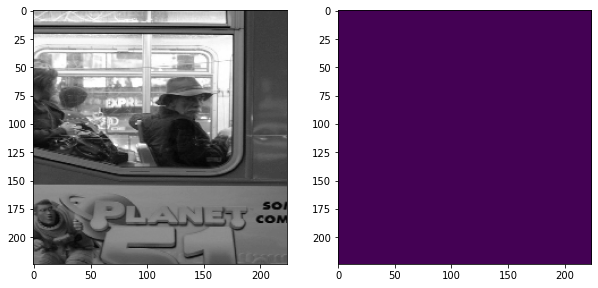

In [ ]:
m = predictions[0]
output1 = np.zeros((224,224))
for i in range(224):
  for j in range(224):
    output1[i,j] = np.argmax(m[i,j,:]) #argmax in the depth

viz(images[0],output1)

(can't figure out where I am going wrong even though the model did give some accuracy in theory.)

**Trying out data Augmentation**

In [ ]:
augment = Sequential([
    RandomFlip(mode = 'horizontal', seed = 42),
    RandomRotation(0.3,seed = 42)
])

In [ ]:
#now creating a train dataset with the augmentation added in:
def aug_train_gen(batch_size):
    c = 0
    while(True): #Infinite Generator
        X = np.zeros((batch_size, 224, 224, 1)).astype('float')
        y = np.zeros((batch_size, 224, 224, 26)).astype('float')
        
        for i in range(c, c+batch_size):
            img, mask = read_img(train_img[i], data='train')
            
            #Augmentations
            #Concatenate Image and Mask to make sure same transformation is applied
            img_mask = tf.concat([img, mask], -1)
            img_mask = augment(img_mask) #Applying Augmentations
            img, mask = img_mask[:,:,0], tf.cast(img_mask[:,:,1], 'uint8')
            
            #Append into the batch array
            X[i-c] = img
            y[i-c] = onehot_mask(mask)
        c += batch_size
        
        if (c + batch_size >= 57023):
            c = 0
            random.shuffle(train_img)
        
        yield X, y

Now just like before, we just need to give this augmented generator function to the model in place the normal train generator.

(due to GPU constraint not going through with it. Ran out of units!)

##Summary/ Learnings:

1. First challenge and learning was dealing with the dataset itself. I have used pycoco library for the easily accessing the coco dataset. Also Downloaded the dataset using Kaggle API. 
2. Next I filtered out the required classes using the annotation file present and created a generator function for both training and validation set. The reason being we can't directly use the training dataset here since it is very large, so need to create this generator fucntion.
3. For creating the masks, I multiplied with each pixel with the correspoing class Id, from the annotation creating a label encoding. Then extrapolated this to create the onehotencoded mask. Later on we get the original mask after prediction from the model using np.argmax and the corresponding index will be the predicted class id for that pixel.
4. Later stage I tried to add augmentations to the training dataset. This will also come under the generator fucntion itself.
5. Next the first model I constructed was based on VGG16. It follows its exact architectute for the encoder part and the decoder part is just reverse of it(deconvolution). The second model was Unet, the model architecture was directly taken from the Unet paper along with the skip connections.
6. The metric that was used for evalution was IOU which will be high if there is significant overlap between the ground truth map and the predicted map. 
7. For the loss function first I tried pixel-wise crossentropyloss. But that was failing, then I tried focal loss, even that was failing. Finally settled on Jaccard loss. 
8. For the number of epochs since this is computational heavy I only did for one epoch.
9. Although theoretically everything should work, the final result was failure and I couldnt not produce relevant mask at the end.


Referrences:
1. For loading and using the COCO dataset: https://github.com/virafpatrawala/COCO-Semantic-Segmentation